In [2]:
import matplotlib.pyplot as plt

def plot_group(group, exclude=[], i=None, j=None):
    """Plot all values in a group (storage, flows, deprive or growth)"""
    plt.figure(figsize=(12,6))
    length = len(next(iter(group.values())))
    i = i if i else 0
    j = j if j else length-1
    steps = [i for i in range(j-i)]
    for currency, values in group.items():
        if sum(values) == 0 or currency in exclude:
            continue
        plt.plot(steps, values[i:j], label=currency)
    plt.legend()
    plt.show()

In [3]:
import matplotlib.pyplot as plt

def plot_currency(data, currency, exclude=[], i=None, j=None):
    """Plot all agents who use a particular currency"""
    
    # Iterate through data and extract all records
    flows = {}
    length = None
    for agent_name, agent_data in data.items():
        if 'flow_records' not in agent_data:
            continue
        for currency_name, currency_data in agent_data['flow_records'].items():
            if currency_name != currency:
                continue
            flow_records = {}
            if not length:
                length = len(currency_data)
            for n, step in enumerate(currency_data):
                # Steps can include records for multiple currencies, 
                # or multiple records for the same currency
                at_least_one = False
                for record in step:
                    if agent_name not in flows:
                        flows[agent_name] = [] + [0] * n
                    if not at_least_one:
                        at_least_one = True
                        flows[agent_name].append(-record['amount'])
                    else:
                        flows[agent_name][-1] -= record['amount']
                if not at_least_one and agent_name in flows:
                    flows[agent_name].append(0)
    
    if not length:
        print("No flow records for", currency)
        return
    
    # Plot data
    plt.figure(figsize=(12,6))
    i = i if i else 0
    j = j if j else length
    steps = [x for x in range(j-i)]
    for agent_name, agent_data in flows.items():
        if agent_name in exclude:
            continue
        pad_zeros = len(steps) - len(agent_data)
        if pad_zeros > 0:
            agent_data += [0] * pad_zeros
        plt.plot(steps, agent_data[i:j], label=agent_name)
    plt.legend(loc='lower right')
    plt.show()

offset_350 555.7568644935062
offset_700 652.1483422742259
full_350 1948.1460305721093
full_700 2354.92778588559


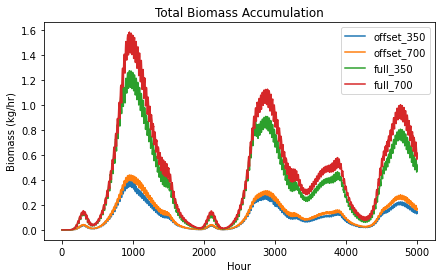

In [8]:
def biomass_production(data):
    output = None
    for agent in data.values():
        if 'flows' in agent and 'biomass' in agent['flows']:
            biomass = agent['flows']['biomass']
            if not output:
                output = biomass
            else:
                output = [a + b for a, b in zip(output, biomass)]
    return output

# Compare biomass production in garden scenarios
fnames = ['offset_350', 'offset_700', 'full_350', 'full_700']
plt.figure(figsize=(7, 4))
for fn in fnames:
    with open(f'simdata_{fn}.json') as f:
        data = json.load(f)
    biomass = biomass_production(data)
    print(fn, sum(biomass))
    plt.plot([i for i in range(len(biomass))], biomass, label=fn)
plt.legend(loc='upper right')
plt.title('Total Biomass Accumulation')
plt.xlabel('Hour')
plt.ylabel('Biomass (kg/hr)')
plt.show()

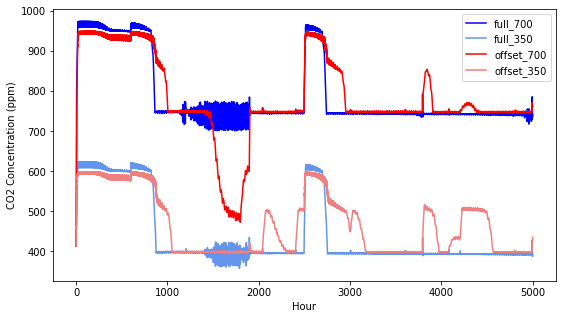

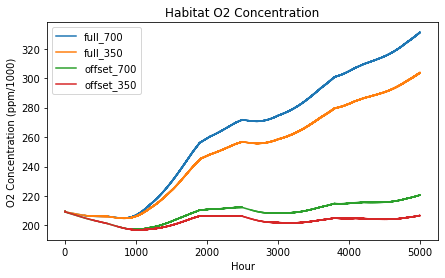

In [9]:
import matplotlib.pyplot as plt
import json

def convert_to_ppm(storage, key='co2'):
    totals = [sum(vals) for vals in zip(*[v for v in storage.values()])]
    converted = [v/t*1e6 for v, t in zip(storage[key], totals)]
    return converted

# Compare atmospheric CO2 in all scenarios
fnames = ['full_700', 'full_350', 'offset_700', 'offset_350']
colors = ['blue', 'cornflowerblue', 'red', 'lightcoral']
plt.figure(figsize=(9, 5))
for fn, color in zip(fnames, colors):
    with open(f'simdata_{fn}.json') as f:
        data = json.load(f)
    hab_co2 = convert_to_ppm(data['crew_habitat_medium']['storage'], 'co2')
    plt.plot([i for i in range(len(hab_co2))], hab_co2, label=fn, color=color)
plt.legend(loc='upper right')
# plt.title('Habitat CO2 Concentration')
plt.xlabel('Hour')
plt.ylabel('CO2 Concentration (ppm)')
plt.show()

# Compare atmospheric O2 in all scenarios
fnames = ['full_700', 'full_350', 'offset_700', 'offset_350']
plt.figure(figsize=(7, 4))
for fn in fnames:
    with open(f'simdata_{fn}.json') as f:
        data = json.load(f)
    hab_o2 = convert_to_ppm(data['crew_habitat_medium']['storage'], 'o2')
    hab_o2 = [o/1e3 for o in hab_o2]
    plt.plot([i for i in range(len(hab_co2))], hab_o2, label=fn)
plt.legend(loc='upper left')
plt.title('Habitat O2 Concentration')
plt.xlabel('Hour')
plt.ylabel('O2 Concentration (ppm/1000)')
plt.show()

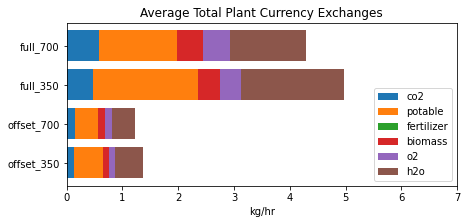

----{scenario}----
co2 18.8% 0.1345 0.1598
potable -21.8% 0.5128 0.4012
fertilizer 22.7% 0.0022 0.0027
biomass 17.4% 0.1111 0.1304
o2 19.6% 0.1074 0.1285
h2o -21.2% 0.5052 0.3982
----{scenario}----
co2 23.2% 0.4758 0.5862
potable -26.0% 1.8712 1.3841
fertilizer 22.5% 0.008 0.0098
biomass 20.9% 0.3896 0.4709
o2 24.4% 0.3798 0.4723
h2o -25.4% 1.8421 1.3741


In [26]:
from collections import defaultdict

plants = ['wheat', 'peanut', 'tomato', 'radish']
def plant_exchanges(data):
    output = defaultdict(int)
    for agent, agent_data in data.items():
        if agent not in plants:
            continue
        for currency, amount in agent_data['flows'].items():
            output[currency] += sum(amount) / len(amount)
    return dict(output)

# Compare average currency exchanges
fnames = ['offset_350', 'offset_700', 'full_350', 'full_700']
datasets = {}
for fn in fnames:
    with open(f'simdata_{fn}.json') as f:
        data = json.load(f)
    datasets[fn] = plant_exchanges(data)
    
fig, ax = plt.subplots(figsize=(7,3))
dataset_labels = list(datasets.keys())
exclude = ['kwh', 'inedible_biomass'] + plants
cumulative = [0] * len(datasets)
for flow in next(iter(datasets.values())):
    if flow in exclude:
        continue
    flows = [ds[flow] for ds in datasets.values()]
    ax.barh(dataset_labels, flows, label=flow, left=cumulative)
    cumulative = [a + b for a, b in zip(flows, cumulative)]
plt.legend(loc='lower right')
plt.xlim([0, 7])
plt.title('Average Total Plant Currency Exchanges')
plt.xlabel('kg/hr')
plt.show()

# Give % change in all currency exchanges from 350 to 700ppm
for scenario in ['offset', 'full']:
    print('----{scenario}----')
    baseline = datasets[f'{scenario}_350']
    elevated = datasets[f'{scenario}_700']
    for currency in baseline.keys():
        if currency in exclude:
            continue
        e = round(elevated[currency], 4)
        b = round(baseline[currency], 4)
        delta = (e-b)/b
        print(currency, f'{round(delta*100, 1)}%', b, e)

Something's wrong with co2_makeup_valve
Something's wrong with co2_makeup_valve
Something's wrong with co2_makeup_valve
Something's wrong with co2_makeup_valve
Something's wrong with co2_makeup_valve


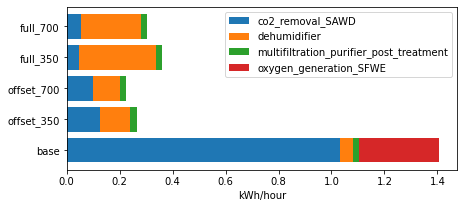

In [10]:
eclss = ['co2_removal_SAWD', 'co2_reduction_sabatier',
         'dehumidifier', 'multifiltration_purifier_post_treatment',
         'co2_makeup_valve', 'solid_waste_aerobic_bioreactor', 
         'oxygen_generation_SFWE', 'urine_recycling_processor_VCD',
         'ch4_removal_agent']
def eclss_electricity(data):
    output = {}
    for agent, agent_data in data.items():
        if agent not in eclss:
            continue
        if 'flows' not in agent_data or 'kwh' not in agent_data['flows']:
            print("Something's wrong with", agent)
            continue
        output[agent] = agent_data['flows']['kwh']
    return output

# Compare ECLSS electricity consumption
fnames = ['base', 'offset_350', 'offset_700', 'full_350', 'full_700']
datasets = {}
for fn in fnames:
    with open(f'simdata_{fn}.json') as f:
        data = json.load(f)
    datasets[fn] = eclss_electricity(data)


show = ['co2_removal_SAWD', 'dehumidifier', 'oxygen_generation_SFWE', 
        'multifiltration_purifier_post_treatment']    
fig, ax = plt.subplots(figsize=(7,3))
dataset_labels = list(datasets.keys())
cumulative = [0] * len(datasets)
after_hour = 2500
for agent in next(iter(datasets.values())):
    if agent not in show:
        continue
    flows = []
    for ds in datasets.values():
        values = ds[agent][after_hour:]
        average = sum(values) / len(values)
        flows.append(average)
    ax.barh(dataset_labels, flows, label=agent, left=cumulative)
    cumulative = [a + b for a, b in zip(flows, cumulative)]
plt.legend(loc='upper right')
# plt.title('Average Hourly Electricity Use, After Hour 2,500')
plt.xlabel('kWh/hour')
plt.show()

In [40]:
after_hour = 2500
for scenario in ['offset', 'full']:
    print(f'----{scenario}----')
    baseline = datasets[f'{scenario}_350']
    elevated = datasets[f'{scenario}_700']
    for currency in baseline.keys():
        if currency in exclude:
            continue
        e = round(sum(elevated[currency][after_hour:]), 4)
        b = round(sum(baseline[currency][after_hour:]), 4)
        delta = 0 if not b else (e-b)/b
        print(currency, f'{round(delta*100, 1)}%', b, e)

----offset----
co2_removal_SAWD -19.5% 315.3256 253.8447
co2_reduction_sabatier 0% 0 0
dehumidifier -13.7% 285.3894 246.4278
multifiltration_purifier_post_treatment 0.0% 60.024 60.024
solid_waste_aerobic_bioreactor 0.0% 3391.356 3391.356
oxygen_generation_SFWE 0% 0 0
urine_recycling_processor_VCD 0.0% 7508.002 7508.002
ch4_removal_agent 0% 0 0
----full----
co2_removal_SAWD 11.9% 119.5436 133.8247
co2_reduction_sabatier 0% 0 0
dehumidifier -21.5% 724.2203 568.3036
multifiltration_purifier_post_treatment 0.0% 60.024 60.024
solid_waste_aerobic_bioreactor 0.0% 3391.356 3391.356
oxygen_generation_SFWE 0% 0 0
urine_recycling_processor_VCD 0.0% 7508.002 7508.002
ch4_removal_agent 0% 0 0


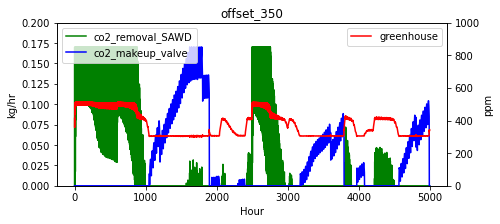

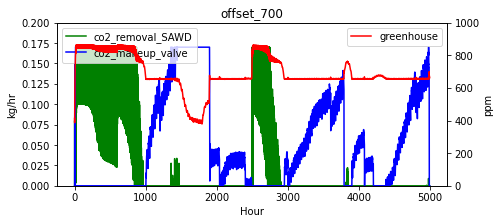

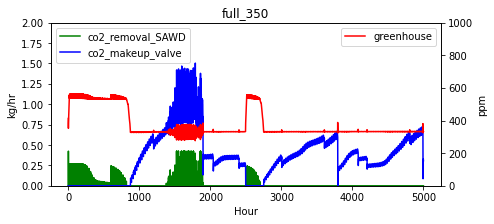

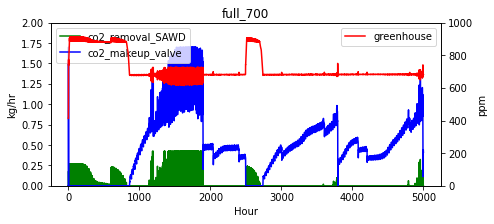

In [42]:
# co2_removal and co2_makeup on left axis, greenhouse co2 on right axis

def convert_to_ppm(storage, key='co2'):
    totals = [sum(vals) for vals in zip(*[v for v in storage.values()])]
    converted = [v/t*1e6 for v, t in zip(storage[key], totals)]
    return converted

def parse_co2(data):
    sawd = data['co2_removal_SAWD']['flows']['co2']
    valve = data['co2_makeup_valve']['flows']['co2']
    greenhouse = [a for a in data.keys() if 'greenhouse' in a][0]
    gh = convert_to_ppm(data[greenhouse]['storage'])
    return sawd, valve, gh

i=None
j=None
fnames = ['offset_350', 'offset_700', 'full_350', 'full_700']
for fn in fnames:
    with open(f'simdata_{fn}.json') as f:
        data = json.load(f)
    sawd, valve, greenhouse = parse_co2(data)
    steps = [s for s in range(len(sawd))]

    fix, ax1 = plt.subplots(figsize=(7,3))
    ax2 = ax1.twinx()

    i = i or 0
    j = j or len(steps) 
    ax1.plot(steps[i:j], sawd[i:j], 'g-', label='co2_removal_SAWD')
    ax1.plot(steps[i:j], valve[i:j], 'b-', label='co2_makeup_valve')
    ax2.plot(steps[i:j], greenhouse[i:j], 'r-', label='greenhouse')

    ax1.set_xlabel('Hour')
    ax1.set_ylabel('kg/hr')
    ax2.set_ylabel('ppm')
    ax1_ylim_max = 0.2 if 'offset' in fn else 2
    ax1.set_ylim([0, ax1_ylim_max])
    ax2.set_ylim([0, 1000])
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(fn)
    plt.show()